In [1]:
%load_ext autoreload
%autoreload 2

import os.path
import numpy as np

# Load in data, this assumed you have a folder in env named data
data_dir = "data"
X_test = np.load(os.path.join(data_dir, "X_test.npy"))
y_test = np.load(os.path.join(data_dir, "y_test.npy"))
person_test = np.load(os.path.join(data_dir, "person_test.npy")).squeeze(axis=1)
X_train_valid = np.load(os.path.join(data_dir, "X_train_valid.npy"))
y_train_valid = np.load(os.path.join(data_dir, "y_train_valid.npy"))
person_train_valid = np.load(os.path.join(data_dir, "person_train_valid.npy")).squeeze(axis=1)

# Predefine some useful variables and fix data a bit
n_class = len(set(y_train_valid))
n_trials = 5
min_y = min(y_train_valid)
y_train_valid = y_train_valid - min_y
y_test = y_test - min_y

In [2]:
# Validate data loaded in correctly and print shapes
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'. format (X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115,)
Person test shape: (443,)


In [3]:
import random
import torch

# Define random seed so that we can reproduce results
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# This is for macbook M1, if you have intel I think you use cuda not mps
# Research what works for your device and change the torch.device
device = torch.device("cuda")
device

device(type='cuda')

In [4]:
# Import the models and functions
from models import *
from trainer import *
import matplotlib.pyplot as plt
import time

In [5]:
# Make data loader for all subjects

# Convert data to tensors
X_tensor_full = torch.FloatTensor(X_test)
y_tensor_full = torch.LongTensor(y_test)

# Combine X and y into a TensorDataset
dataset_full = TensorDataset(X_tensor_full, y_tensor_full)

# Prepare dataloaders
test_dataloader_full = DataLoader(dataset_full, batch_size=256, shuffle=False)

## Test Accuracy v.s. Time Bins Used (100 - 1000, 100 bin steps)

In [6]:
ls = np.arange(100, 1001, 100)
train_accs_sweep = []
valid_accs_sweep = []
test_accs_sweep = []
times_sweep = []

for l in ls:
    print(f"{l=}")
    X_train_valid_sub = X_train_valid[:, :, :l]
    X_test_sub = X_test[:, :, :l]
     
    # make data loader
    # Convert data to tensors
    X_tensor_sub = torch.FloatTensor(X_test_sub)
    y_tensor_sub = torch.LongTensor(y_test)

    # Combine X and y into a TensorDataset
    dataset_sub = TensorDataset(X_tensor_sub, y_tensor_sub)

    # Prepare dataloaders
    test_dataloader_sub= DataLoader(dataset_sub, batch_size=256, shuffle=False)

    # CNN
    start = time.time()
    cnn_sub = CNN(input_size=X_train_valid_sub.shape[1:], N=n_class).to(device)
    valid_acc, trains, valids = fit(cnn_sub, X_train_valid_sub, y_train_valid, device, epochs=500)
    test_acc, _ = evaluate(cnn_sub, test_dataloader_sub, device)
    end = time.time()
    train_accs_sweep.append(trains)
    valid_accs_sweep.append(valids)
    test_accs_sweep.append(test_acc)
    times_sweep.append(end-start)

l=100


  0%|          | 0/500 [00:00<?, ?it/s]

Best valid accuracy: 0.5792
l=200


  0%|          | 0/500 [00:00<?, ?it/s]

Best valid accuracy: 0.64539
l=300


  0%|          | 0/500 [00:00<?, ?it/s]

Best valid accuracy: 0.68558
l=400


  0%|          | 0/500 [00:00<?, ?it/s]

Best valid accuracy: 0.74468
l=500


  0%|          | 0/500 [00:00<?, ?it/s]

Best valid accuracy: 0.72577
l=600


  0%|          | 0/500 [00:00<?, ?it/s]

Best valid accuracy: 0.74468
l=700


  0%|          | 0/500 [00:00<?, ?it/s]

Best valid accuracy: 0.71631
l=800


  0%|          | 0/500 [00:00<?, ?it/s]

Best valid accuracy: 0.70922
l=900


  0%|          | 0/500 [00:00<?, ?it/s]

Best valid accuracy: 0.68322
l=1000


  0%|          | 0/500 [00:00<?, ?it/s]

Best valid accuracy: 0.7305


In [7]:
np.save('Time_bin_data/train_accs_sweep.npy', train_accs_sweep)
np.save('Time_bin_data/valid_accs_sweep.npy', valid_accs_sweep)
np.save('Time_bin_data/test_accs_sweep.npy', test_accs_sweep)
np.save('Time_bin_data/times_sweep.npy', times_sweep)

In [ ]:
# Directly run this block instead of above sweep if opening this notebook fresh

train_accs_sweep = np.load('Time_bin_data/train_accs_sweep.npy')
valid_accs_sweep = np.load('Time_bin_data/valid_accs_sweep.npy')
test_accs_sweep = np.load('Time_bin_data/test_accs_sweep.npy')
times_sweep = np.load('Time_bin_data/times_sweep.npy')

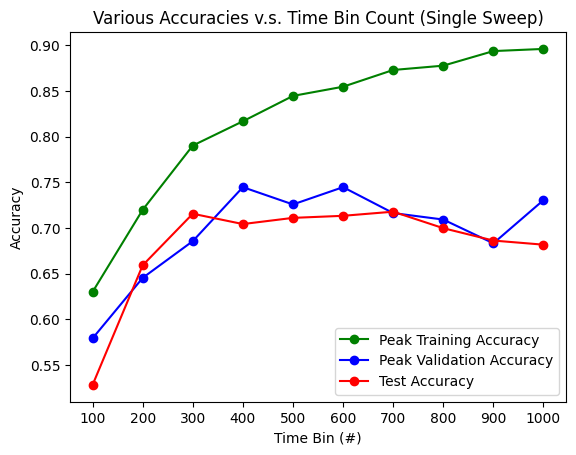

[0.52822, 0.65914, 0.71558, 0.70429, 0.71106, 0.71332, 0.71783, 0.69977, 0.68623, 0.68172]


In [139]:
ls = np.arange(100, 1001, 100)
plt.figure()
plt.plot(ls, [np.max(x) for x in train_accs_sweep], 'go-')
plt.plot(ls, [np.max(x) for x in valid_accs_sweep], 'bo-')
plt.plot(ls, test_accs_sweep, 'ro-')
plt.title("Various Accuracies v.s. Time Bin Count (Single Sweep)")
plt.xticks(ls)
plt.xlabel('Time Bin (#)')
plt.ylabel('Accuracy')
plt.legend(['Peak Training Accuracy', 'Peak Validation Accuracy', 'Test Accuracy'])
plt.show()
print(test_accs_sweep)

Text(0.5, 1.0, 'Total Training Time v.s. Time Bin Count')

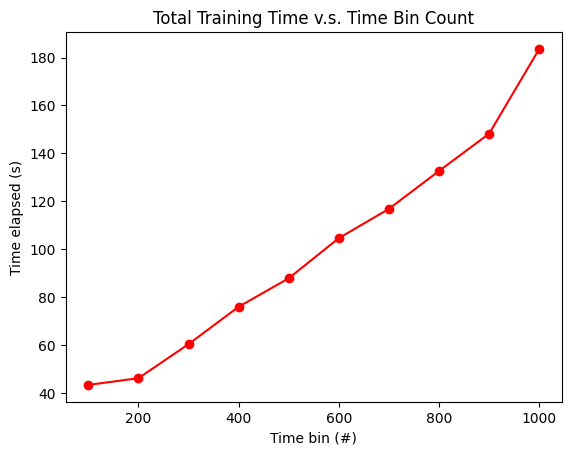

In [9]:
plt.figure()
plt.plot(ls, times_sweep, 'ro-')
plt.ylabel("Time elapsed (s)")
plt.xlabel("Time bin (#)")
plt.title("Total Training Time v.s. Time Bin Count")

## Statistical Analysis on Effective Range (300, 400, 500, 600, 700) x10 Each

In [11]:
train_accs_focus = []
valid_accs_focus = []
test_accs_focus = []
times_focus = []
num_trials = 10

### L = 300

In [13]:
l = 300

X_train_valid_sub = X_train_valid[:, :, :l]
X_test_sub = X_test[:, :, :l]
    
# make data loader
# Convert data to tensors
X_tensor_sub = torch.FloatTensor(X_test_sub)
y_tensor_sub = torch.LongTensor(y_test)

# Combine X and y into a TensorDataset
dataset_sub = TensorDataset(X_tensor_sub, y_tensor_sub)

# Prepare dataloaders
test_dataloader_sub= DataLoader(dataset_sub, batch_size=256, shuffle=False)

train_accs_sub = []
valid_accs_sub = []
test_accs_sub = []
times_sub = []

for trial in range(num_trials):
    start = time.time()
    cnn_sub = CNN(input_size=X_train_valid_sub.shape[1:], N=n_class).to(device)
    valid_acc, trains, valids = fit(cnn_sub, X_train_valid_sub, y_train_valid, device, epochs=300)
    test_acc, _ = evaluate(cnn_sub, test_dataloader_sub, device)
    end = time.time()
    train_accs_sub.append(np.max(trains))
    valid_accs_sub.append(valid_acc)
    test_accs_sub.append(test_acc)
    times_sub.append(end-start)

train_accs_focus.append(train_accs_sub)
valid_accs_focus.append(valid_accs_sub)
test_accs_focus.append(test_accs_sub)
times_focus.append(times_sub)

np.save('Time_bin_data/train_accs_focus.npy', train_accs_focus)
np.save('Time_bin_data/valid_accs_focus.npy', valid_accs_focus)
np.save('Time_bin_data/test_accs_focus.npy', test_accs_focus)
np.save('Time_bin_data/times_focus.npy', times_focus)

  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.71631


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.70686


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.73522


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.73522


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.71158


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.69267


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.73759


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.73286


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.7234


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.68558


### L = 400

In [18]:
l = 400

X_train_valid_sub = X_train_valid[:, :, :l]
X_test_sub = X_test[:, :, :l]
    
# make data loader
# Convert data to tensors
X_tensor_sub = torch.FloatTensor(X_test_sub)
y_tensor_sub = torch.LongTensor(y_test)

# Combine X and y into a TensorDataset
dataset_sub = TensorDataset(X_tensor_sub, y_tensor_sub)

# Prepare dataloaders
test_dataloader_sub= DataLoader(dataset_sub, batch_size=256, shuffle=False)

train_accs_sub = []
valid_accs_sub = []
test_accs_sub = []
times_sub = []

for trial in range(num_trials):
    start = time.time()
    cnn_sub = CNN(input_size=X_train_valid_sub.shape[1:], N=n_class).to(device)
    valid_acc, trains, valids = fit(cnn_sub, X_train_valid_sub, y_train_valid, device, epochs=300)
    test_acc, _ = evaluate(cnn_sub, test_dataloader_sub, device)
    end = time.time()
    train_accs_sub.append(np.max(trains))
    valid_accs_sub.append(valid_acc)
    test_accs_sub.append(test_acc)
    times_sub.append(end-start)

train_accs_focus.append(train_accs_sub)
valid_accs_focus.append(valid_accs_sub)
test_accs_focus.append(test_accs_sub)
times_focus.append(times_sub)

np.save('Time_bin_data/train_accs_focus.npy', train_accs_focus)
np.save('Time_bin_data/valid_accs_focus.npy', valid_accs_focus)
np.save('Time_bin_data/test_accs_focus.npy', test_accs_focus)
np.save('Time_bin_data/times_focus.npy', times_focus)

  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.72104


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.69267


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.7305


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.74232


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.74704


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.7234


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.75177


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.74468


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.72104


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.76832


### L = 500

In [27]:
l = 500

X_train_valid_sub = X_train_valid[:, :, :l]
X_test_sub = X_test[:, :, :l]
    
# make data loader
# Convert data to tensors
X_tensor_sub = torch.FloatTensor(X_test_sub)
y_tensor_sub = torch.LongTensor(y_test)

# Combine X and y into a TensorDataset
dataset_sub = TensorDataset(X_tensor_sub, y_tensor_sub)

# Prepare dataloaders
test_dataloader_sub= DataLoader(dataset_sub, batch_size=256, shuffle=False)

train_accs_sub = []
valid_accs_sub = []
test_accs_sub = []
times_sub = []

for trial in range(num_trials):
    start = time.time()
    cnn_sub = CNN(input_size=X_train_valid_sub.shape[1:], N=n_class).to(device)
    valid_acc, trains, valids = fit(cnn_sub, X_train_valid_sub, y_train_valid, device, epochs=300)
    test_acc, _ = evaluate(cnn_sub, test_dataloader_sub, device)
    end = time.time()
    train_accs_sub.append(np.max(trains))
    valid_accs_sub.append(valid_acc)
    test_accs_sub.append(test_acc)
    times_sub.append(end-start)

train_accs_focus.append(train_accs_sub)
valid_accs_focus.append(valid_accs_sub)
test_accs_focus.append(test_accs_sub)
times_focus.append(times_sub)

np.save('Time_bin_data/train_accs_focus.npy', train_accs_focus)
np.save('Time_bin_data/valid_accs_focus.npy', valid_accs_focus)
np.save('Time_bin_data/test_accs_focus.npy', test_accs_focus)
np.save('Time_bin_data/times_focus.npy', times_focus)

  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.74941


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.76596


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.73759


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.69976


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.74468


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.72577


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.73522


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.74232


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.72104


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.73759


### L = 600

In [28]:
l = 600

X_train_valid_sub = X_train_valid[:, :, :l]
X_test_sub = X_test[:, :, :l]
    
# make data loader
# Convert data to tensors
X_tensor_sub = torch.FloatTensor(X_test_sub)
y_tensor_sub = torch.LongTensor(y_test)

# Combine X and y into a TensorDataset
dataset_sub = TensorDataset(X_tensor_sub, y_tensor_sub)

# Prepare dataloaders
test_dataloader_sub= DataLoader(dataset_sub, batch_size=256, shuffle=False)

train_accs_sub = []
valid_accs_sub = []
test_accs_sub = []
times_sub = []

for trial in range(num_trials):
    start = time.time()
    cnn_sub = CNN(input_size=X_train_valid_sub.shape[1:], N=n_class).to(device)
    valid_acc, trains, valids = fit(cnn_sub, X_train_valid_sub, y_train_valid, device, epochs=300)
    test_acc, _ = evaluate(cnn_sub, test_dataloader_sub, device)
    end = time.time()
    train_accs_sub.append(np.max(trains))
    valid_accs_sub.append(valid_acc)
    test_accs_sub.append(test_acc)
    times_sub.append(end-start)

train_accs_focus.append(train_accs_sub)
valid_accs_focus.append(valid_accs_sub)
test_accs_focus.append(test_accs_sub)
times_focus.append(times_sub)

np.save('Time_bin_data/train_accs_focus.npy', train_accs_focus)
np.save('Time_bin_data/valid_accs_focus.npy', valid_accs_focus)
np.save('Time_bin_data/test_accs_focus.npy', test_accs_focus)
np.save('Time_bin_data/times_focus.npy', times_focus)

  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.71631


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.72104


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.71158


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.7234


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.71158


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.71868


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.74232


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.7305


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.72577


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.72104


### L = 700

In [30]:
l = 700

X_train_valid_sub = X_train_valid[:, :, :l]
X_test_sub = X_test[:, :, :l]
    
# make data loader
# Convert data to tensors
X_tensor_sub = torch.FloatTensor(X_test_sub)
y_tensor_sub = torch.LongTensor(y_test)

# Combine X and y into a TensorDataset
dataset_sub = TensorDataset(X_tensor_sub, y_tensor_sub)

# Prepare dataloaders
test_dataloader_sub= DataLoader(dataset_sub, batch_size=256, shuffle=False)

train_accs_sub = []
valid_accs_sub = []
test_accs_sub = []
times_sub = []

for trial in range(num_trials):
    start = time.time()
    cnn_sub = CNN(input_size=X_train_valid_sub.shape[1:], N=n_class).to(device)
    valid_acc, trains, valids = fit(cnn_sub, X_train_valid_sub, y_train_valid, device, epochs=300)
    test_acc, _ = evaluate(cnn_sub, test_dataloader_sub, device)
    end = time.time()
    train_accs_sub.append(np.max(trains))
    valid_accs_sub.append(valid_acc)
    test_accs_sub.append(test_acc)
    times_sub.append(end-start)

train_accs_focus.append(train_accs_sub)
valid_accs_focus.append(valid_accs_sub)
test_accs_focus.append(test_accs_sub)
times_focus.append(times_sub)

np.save('Time_bin_data/train_accs_focus.npy', train_accs_focus)
np.save('Time_bin_data/valid_accs_focus.npy', valid_accs_focus)
np.save('Time_bin_data/test_accs_focus.npy', test_accs_focus)
np.save('Time_bin_data/times_focus.npy', times_focus)

  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.69031


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.72813


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.72104


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.72577


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.71631


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.68794


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.72577


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.71631


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.73286


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.70922


L = 800

In [71]:
l = 800

X_train_valid_sub = X_train_valid[:, :, :l]
X_test_sub = X_test[:, :, :l]
    
# make data loader
# Convert data to tensors
X_tensor_sub = torch.FloatTensor(X_test_sub)
y_tensor_sub = torch.LongTensor(y_test)

# Combine X and y into a TensorDataset
dataset_sub = TensorDataset(X_tensor_sub, y_tensor_sub)

# Prepare dataloaders
test_dataloader_sub= DataLoader(dataset_sub, batch_size=256, shuffle=False)

train_accs_sub = []
valid_accs_sub = []
test_accs_sub = []
times_sub = []

for trial in range(num_trials):
    start = time.time()
    cnn_sub = CNN(input_size=X_train_valid_sub.shape[1:], N=n_class).to(device)
    valid_acc, trains, valids = fit(cnn_sub, X_train_valid_sub, y_train_valid, device, epochs=300)
    test_acc, _ = evaluate(cnn_sub, test_dataloader_sub, device)
    end = time.time()
    train_accs_sub.append(np.max(trains))
    valid_accs_sub.append(valid_acc)
    test_accs_sub.append(test_acc)
    times_sub.append(end-start)

train_accs_focus.append(train_accs_sub)
valid_accs_focus.append(valid_accs_sub)
test_accs_focus.append(test_accs_sub)
times_focus.append(times_sub)

np.save('Time_bin_data/train_accs_focus.npy', train_accs_focus)
np.save('Time_bin_data/valid_accs_focus.npy', valid_accs_focus)
np.save('Time_bin_data/test_accs_focus.npy', test_accs_focus)
np.save('Time_bin_data/times_focus.npy', times_focus)

  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.72104


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.66903


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.71158


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.70449


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.69976


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.69504


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.73995


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.7305


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.74232


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.71631


In [ ]:
# Use this block to retrieve and plot previous results

train_accs_focus = np.load('Time_bin_data/train_accs_focus.npy')
valid_accs_focus = np.load('Time_bin_data/valid_accs_focus.npy')
test_accs_focus = np.load('Time_bin_data/test_accs_focus.npy')
times_focus = np.load('Time_bin_data/times_focus.npy')

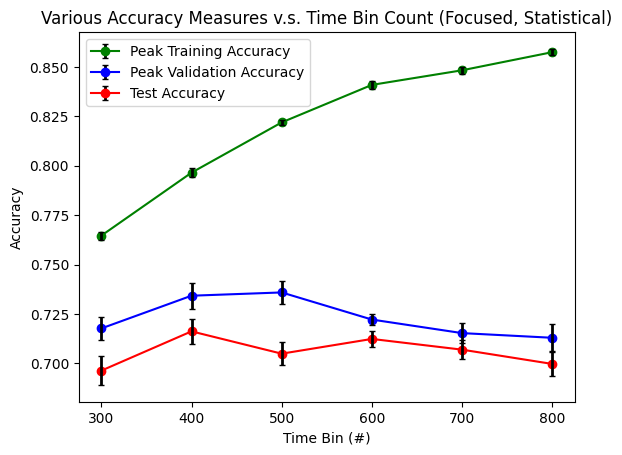

In [140]:
from scipy import stats

ls_focus = np.arange(300, 801, 100)

plt.figure()
plt.errorbar(ls_focus, [np.mean(x) for x in train_accs_focus], [stats.sem(x) for x in train_accs_focus], fmt='go-', ecolor='black', elinewidth=2, capsize=2, barsabove=True)
plt.errorbar(ls_focus, [np.mean(x) for x in valid_accs_focus], [stats.sem(x) for x in valid_accs_focus], fmt='bo-', ecolor='black', elinewidth=2, capsize=2, barsabove=True)
plt.errorbar(ls_focus, [np.mean(x) for x in test_accs_focus], [stats.sem(x) for x in test_accs_focus], fmt='ro-', ecolor='black', elinewidth=2, capsize=2, barsabove=True)
plt.title("Various Accuracy Measures v.s. Time Bin Count (Focused, Statistical)")
plt.xlabel('Time Bin (#)')
plt.ylabel('Accuracy')
plt.legend(['Peak Training Accuracy', 'Peak Validation Accuracy', 'Test Accuracy'])
plt.show()

Test Accuracies: [0.696387, 0.7162510000000001, 0.704966, 0.7124159999999999, 0.7069970000000001, 0.699774]
Standard Errors: [0.007226767380909517, 0.006305010080175222, 0.005953978165898831, 0.004232361883288229, 0.004636057724211617, 0.006295109777526607]
2 Sample T-Test p-values vs 400:
0.052990266602629746
0.2095601008366212
0.6196745873937728
0.25240438703435375
0.08089892599927588


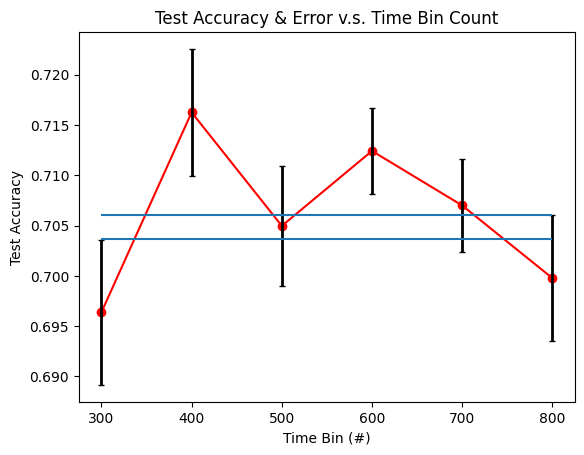

In [134]:
plt.errorbar(ls_focus, [np.mean(x) for x in test_accs_focus], [stats.sem(x) for x in test_accs_focus], fmt='ro-', ecolor='black', elinewidth=2, capsize=2, barsabove=True)
plt.hlines(0.70607, 300, 800)
plt.hlines(0.70363, 300, 800)
plt.title("Test Accuracy & Error v.s. Time Bin Count")
plt.xlabel('Time Bin (#)')
plt.ylabel('Test Accuracy')
print("Test Accuracies: " + str([np.mean(x) for x in test_accs_focus]))
print("Standard Errors: " + str([stats.sem(x) for x in test_accs_focus]))
print("2 Sample T-Test p-values vs 400:")
for i in [0, 2, 3, 4, 5]:
    t, p = stats.ttest_ind(a=test_accs_focus[i], b=test_accs_focus[1])
    print(p)

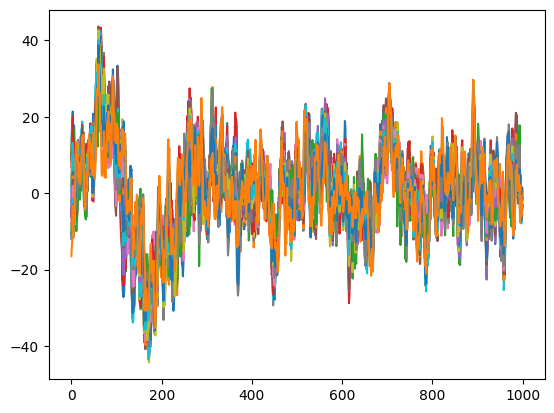

In [122]:
time = np.arange(1000)
plt.figure()
for i in range(22):
    plt.plot(time, X_train_valid[1][i])